In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, MaxPooling1D, concatenate,
    GlobalAveragePooling1D, Multiply, Reshape
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [4]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [7]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [8]:
def se_block(input_tensor, ratio=16):
    channel = input_tensor.shape[-1]
    se = GlobalAveragePooling1D()(input_tensor)
    se = Dense(channel // ratio, activation='relu')(se)
    se = Dense(channel, activation='sigmoid')(se)
    se = Reshape((1, channel))(se)
    x = Multiply()([input_tensor, se])
    return x

In [9]:
# Level 1
inputs1_1= Input(shape=(n_timesteps,n_features))
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1_1)
conv1_1 = se_block(conv1_1)
inputs1_2= Input(shape=(n_timesteps,n_features))
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs1_2)
conv1_2 = se_block(conv1_2)
inputs1_3= Input(shape=(n_timesteps,n_features))
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs1_3)
conv1_3 = se_block(conv1_3)
inputs1_4= Input(shape=(n_timesteps,n_features))
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(inputs1_4)
conv1_4 = se_block(conv1_4)

merged_1 = concatenate([conv1_1, conv1_2, conv1_3, conv1_4], axis=1)
pool_1 = MaxPooling1D(pool_size=5)(merged_1)

# Level 2
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_1)
conv2_1 = se_block(conv2_1)
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu')(pool_1)
conv2_2 = se_block(conv2_2)
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu')(pool_1)
conv2_3 = se_block(conv2_3)
conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu')(pool_1)
conv2_4 = se_block(conv2_4)

merged_2 = concatenate([conv2_1, conv2_2, conv2_3, conv2_4], axis=1)
pool_2 = MaxPooling1D(pool_size=5)(merged_2)

# Level 3
conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool_2)
conv3_1 = se_block(conv3_1)
conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu')(pool_2)
conv3_2 = se_block(conv3_2)
conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu')(pool_2)
conv3_3 = se_block(conv3_3)
conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu')(pool_2)
conv3_4 = se_block(conv3_4)

merged_3 = concatenate([conv3_1, conv3_2, conv3_3, conv3_4], axis=1)
pool_3 = MaxPooling1D(pool_size=5)(merged_3)

flat_cnn = Flatten()(pool_3)
dense = Dense(512, activation='relu')(flat_cnn)
outputs = Dense(n_outputs, activation='softmax')(dense)

cnn_se_model = Model([inputs1_1, inputs1_2, inputs1_3, inputs1_4], outputs)
cnn_se_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_se_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 128)  │      3,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 124, 128)  │      5,888 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 122, 128)  │      8,192 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 120, 128)  │     10,496 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │      1,032 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │      1,032 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │      1,032 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │      1,032 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      1,152 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      1,152 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │      1,152 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │      1,152 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ dense_1[0][0]   

 Total params: 1,190,718 (4.54 MB)

 Trainable params: 1,190,718 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_history = cnn_se_model.fit(
    x=[X_train, X_train, X_train, X_train],
    y=y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 57s 246ms/step - accuracy: 0.6371 - loss: 0.8439 - val_accuracy: 0.9474 - val_loss: 0.1090
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 261ms/step - accuracy: 0.9446 - loss: 0.1335 - val_accuracy: 0.9610 - val_loss: 0.1108
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - accuracy: 0.9545 - loss: 0.1064 - val_accuracy: 0.9457 - val_loss: 0.1330
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 81s 252ms/step - accuracy: 0.9550 - loss: 0.1135 - val_accuracy: 0.9593 - val_loss: 0.0985
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 252ms/step - accuracy: 0.9586 - loss: 0.0983 - val_accuracy: 0.9559 - val_loss: 0.0961
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 38s 230ms/step - accuracy: 0.9602 - loss: 0.0967 - val_accuracy: 0.9593 - val_loss: 0.0872
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.9604 - loss: 0.0956 - val_accuracy: 0.9474 - val_loss: 0.1136
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 38s 213ms/step - accuracy: 0.9460 - loss: 0

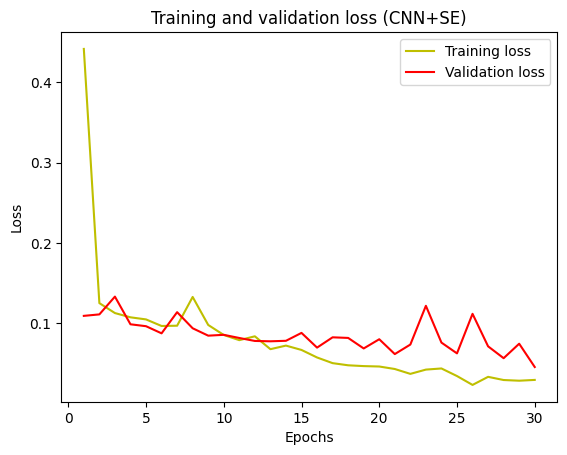

In [11]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (CNN+SE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

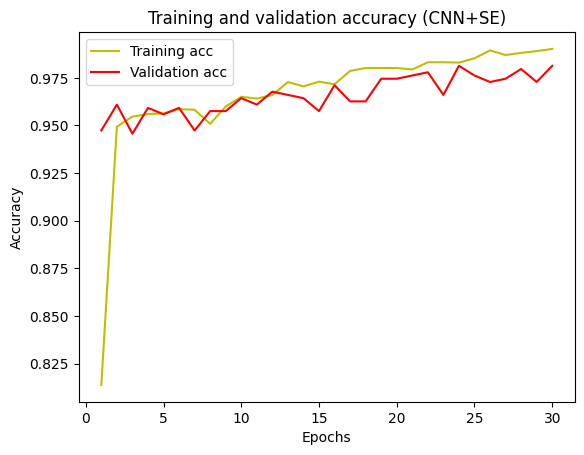

In [12]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (CNN+SE)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step
[[484   2   6   0   4   0]
 [ 10 438  23   0   0   0]
 [  2   3 414   1   0   0]
 [  1   0   0 415  71   4]
 [  2   0   0  48 482   0]
 [  0   0   0   0   0 537]]
0.9399389209365456
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       496
           1       0.99      0.93      0.96       471
           2       0.93      0.99      0.96       420
           3       0.89      0.85      0.87       491
           4       0.87      0.91      0.89       532
           5       0.99      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



<Axes: >

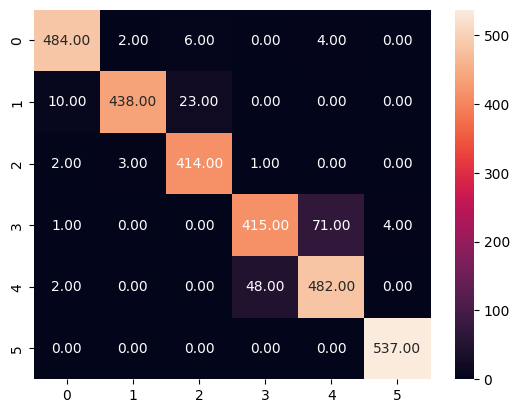

In [13]:
pred = cnn_se_model.predict([testX, testX, testX, testX])
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')